# Try to add a nifty model for sampling the input map

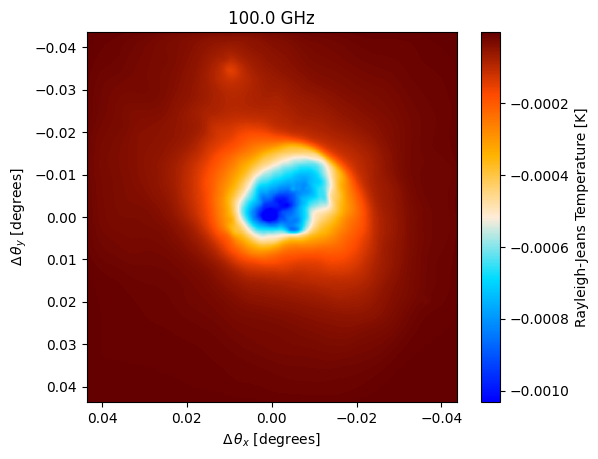

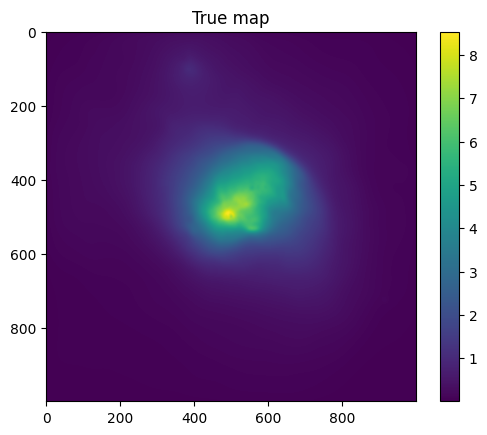

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import maria

import jax.numpy as jnp

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()
plt.show()

# Sava mapdata as jax array
mapdata_input = np.float64((input_map.data[0].T)*-1e7)

plt.imshow(mapdata_input)
plt.colorbar()
plt.title('True map')
plt.show()

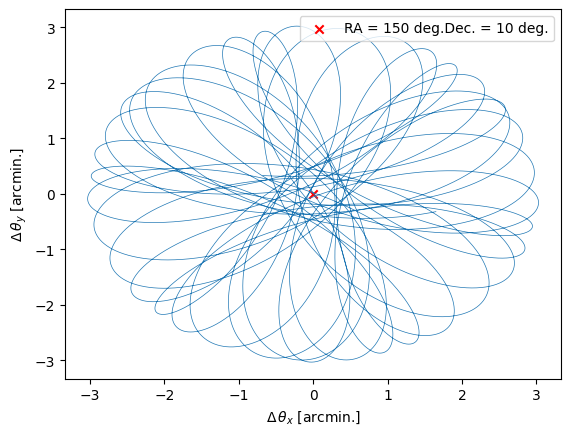

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

In [3]:
instrument = maria.get_instrument('MUSTANG-2')
# instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       noise=False,
                      #  atmosphere="2d",
                    #    cmb="generate",
                      )

tod_truthmap = sim_truthmap.run()

2024-07-26 15:18:00.777 INFO: Constructed instrument.
2024-07-26 15:18:00.777 INFO: Constructed plan.
2024-07-26 15:18:00.778 INFO: Constructed site.


2024-07-26 15:18:01.297 INFO: Constructed boresight.
2024-07-26 15:18:01.548 INFO: Constructed offsets.


Initialized base in 771 ms.


Sampling map (m2/f093):   0%|          | 0/1 [00:00<?, ?it/s]

INPUTS map_power:
dx[band_mask] [[-1.9628652e-04 -1.9276464e-04 -1.8971233e-04 ...  4.7382721e-04
   4.7687953e-04  4.7993180e-04]
 [-2.7118466e-04 -2.6813237e-04 -2.6484532e-04 ...  3.9798603e-04
   4.0103839e-04  4.0409074e-04]
 [-2.4559547e-04 -2.4230835e-04 -2.3878644e-04 ...  4.2851540e-04
   4.3156778e-04  4.3462013e-04]
 ...
 [-4.0474121e-04 -4.0145448e-04 -3.9816773e-04 ...  2.2961208e-04
   2.3266416e-04  2.3571622e-04]
 [-5.1400432e-04 -5.1071699e-04 -5.0742965e-04 ...  1.8691758e-04
   1.8973541e-04  1.9302288e-04]
 [-7.4873149e-04 -7.4544450e-04 -7.4215751e-04 ... -8.7813336e-05
  -8.4760992e-05 -8.1708640e-05]]
dy[band_mask] [[ 9.6262323e-05  9.6013559e-05  9.5849646e-05 ... -9.4737858e-05
  -9.3942297e-05 -9.2972456e-05]
 [ 1.0961054e-04  1.0944663e-04  1.0916806e-04 ... -8.6159685e-05
  -8.5334323e-05 -8.4453910e-05]
 [ 3.7784415e-05  3.7595251e-05  3.7291429e-05 ... -1.5610579e-04
  -1.5535494e-04 -1.5441491e-04]
 ...
 [ 6.7048648e-04  6.7023770e-04  6.7003362e-04 ...  

Sampling map (m2/f093): 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]

RESULT map_power [[-2.89472917e-04 -2.91251052e-04 -2.94170296e-04 ... -1.18353117e-05
  -1.17962257e-05 -1.17682908e-05]
 [-1.76057336e-04 -1.80517965e-04 -1.85242337e-04 ... -1.67147933e-05
  -1.64782554e-05 -1.62489741e-05]
 [-2.06965466e-04 -2.11649272e-04 -2.16377273e-04 ... -1.04865497e-05
  -1.04039248e-05 -1.03382748e-05]
 ...
 [-6.39621073e-06 -6.44751231e-06 -6.49996203e-06 ... -3.65862399e-05
  -3.62912146e-05 -3.59878298e-05]
 [-1.37335174e-05 -1.40119731e-05 -1.42876457e-05 ... -4.98222054e-06
  -4.95793793e-06 -4.93022444e-06]
 [-3.98390692e-06 -4.18826797e-06 -4.38506822e-06 ... -3.86939927e-04
  -3.92919198e-04 -3.99751380e-04]]


In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

Running mapper (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]

(1, 1000, 1000)
mean: -8.726027824180198e-05


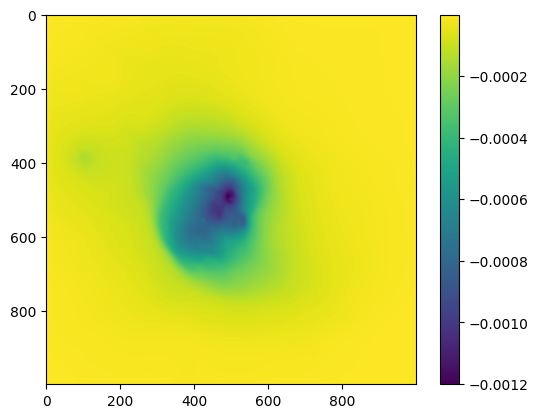

In [112]:
from maria.map.mappers import BinMapper

mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

# output_truthmap.plot()

# mapdata_truth = np.float64((output_truthmap.data[0])*-1e4)
# mapdata_truth = np.float64(-1.*(output_truthmap.data[0]))
# mapdata_truth = np.float64(output_truthmap.data[0])
mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print(mapdata_truth.shape)
print("mean:", mapdata_truth.mean())

plt.imshow(mapdata_truth[0])
plt.colorbar()

# Next, initialise nifty prior model

In [37]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2'

import jax
import nifty8.re as jft
import matplotlib.pyplot as plt

from jax import random

seed = 42
key = random.PRNGKey(seed)

In [113]:
# dims = (128, 128)
dims = (1000, 1000)
# dims = (500, 500)

# Map model

# correlated field zero mode GP offset and stddev
# mean: -0.0001326779640292624
# mean: -8.726027824180198e-05
# cf_zm_map = dict(offset_mean=1.3e-4, offset_std=(1e-5, 1e-5))
cf_zm_map = dict(offset_mean=-8.7e-5, offset_std=(1e-6, 1e-6))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1.0e0, 1e-1), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-1.5e0, 1e0), # power-spectrum slope in log-log space in frequency domain (Fourier space)
    flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims, distances=1.0 / dims[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [114]:
# jax compatible rewrite if beams.separably_filter
def separably_filter(data, F, tol=1e-2, return_filter=False):
    """
    This is more efficient than 2d convolution
    """

    assert data.ndim == 2

    # u, s, v = np.linalg.svd(F)
    u, s, v = jax.numpy.linalg.svd(F)
    effective_filter = 0
    filtered_image = 0

    # pad data array to achieve mirroring effect
    data = jax.numpy.column_stack([data[:,0], data, data[:, -1]]) # axis=1
    data = jax.numpy.vstack([data[0], data, data[-1]]) # axis=0

    for m in range(len(F)):
        effective_filter += s[m] * u[:, m : m + 1] @ v[m : m + 1]
        
        # TODO: jax convolution works slightly different than in scipy. Fix here!
        # filtered_image += s[m] * jax.scipy.signal.convolve(
        #     jax.scipy.signal.convolve(data, u[:, m], ), v[m],
        # )
        
        # Turn kernels into shape (1, dim) to work in nd function
        u_kernel = jax.numpy.broadcast_to(u[:, m], (1, u[:, m].size))
        v_kernel = jax.numpy.broadcast_to(u[:, m], (1, v[m].size))
        
        # step1 = jax.scipy.signal.convolve(data, u_kernel.T, mode='same')
        # print("step1 shape", step1.shape)
        # step2 = jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')
        # print("step2 shape", step2.shape)
        # print("s[m] shape", s[m].shape)
        
        filtered_image += s[m] * jax.scipy.signal.convolve(jax.scipy.signal.convolve(data, u_kernel.T, mode='same'), v_kernel, mode='same')[1:-1, 1:-1]

        # if np.abs(F - effective_filter).mean() < tol:
        # if jax.numpy.abs(F - effective_filter).mean() < tol:
        #     break

    return (filtered_image, effective_filter) if return_filter else filtered_image

In [115]:
import scipy.interpolate
from tqdm import tqdm
from maria.constants import k_B
from maria.instrument import beams
import warnings

def sample_maps(sim_truthmap, dx, dy, instrument, resolution, x_side, y_side):
    # dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)

    # data = {}
    # sim_truthmap.data["map"] = 1e-16 * np.random.standard_normal(size=dx.shape)
    # data["map"] = jax.numpy.asarray(1e-16 * np.random.standard_normal(size=dx.shape))
    data_map = jax.numpy.array(1e-16 * np.random.standard_normal(size=dx.shape))

    # pbar = tqdm(sim_truthmap.instrument.bands, disable=not sim_truthmap.verbose)
    # pbar = tqdm(instrument.bands)
    pbar = instrument.bands

    for band in pbar:
        # pbar.set_description(f"Sampling map ({band.name})")

        # band_mask = sim_truthmap.instrument.dets.band_name == band.name
        band_mask = instrument.dets.band_name == band.name

        nu = np.linspace(band.nu_min, band.nu_max, 64)
        TRJ = jax.scipy.interpolate.RegularGridInterpolator(
            (jax.numpy.array([100.]),),
            jax.numpy.array(sim_truthmap),
            fill_value=None,
            bounds_error=False,
            method='nearest',
        )(nu)

        power_map = (
            1e12
            * k_B
            # * np.trapz(band.passband(nu)[:, None, None] * TRJ, axis=0, x=1e9 * nu)
            * jax.numpy.trapezoid(band.passband(nu)[:, None, None] * TRJ, axis=0, x=1e9 * nu)
        )

        # nu is in GHz, f is in Hz
        nu_fwhm = beams.compute_angular_fwhm(
            # fwhm_0=sim_truthmap.instrument.dets.primary_size.mean(),
            fwhm_0=instrument.dets.primary_size.mean(),
            z=np.inf,
            f=1e9 * band.center,
        ) 
        
        nu_map_filter = jax.numpy.asarray( beams.construct_beam_filter(
            # fwhm=nu_fwhm, res=sim_truthmap.map.resolution
            fwhm=nu_fwhm, res=resolution
        ) )
        
        filtered_power_map = separably_filter(power_map, nu_map_filter)
        
        # Need to invert x_side and y_side for jax interpolation:
        x_side = -1.*x_side
        y_side = -1.*y_side
        
        # np:
        # map_power_numpy = sp.interpolate.RegularGridInterpolator(
        #     (np.array(x_side), np.array(y_side)),
        #     np.array(filtered_power_map),
        #     fill_value=0.,
        #     bounds_error=False,
        #     method="linear",
        # )((dx[band_mask][0], dy[band_mask][0]))
        
        # jax:
        map_power = jax.scipy.interpolate.RegularGridInterpolator(
            (x_side, y_side), # length N=2 sequence of arrays with grid coords
            filtered_power_map, # N=2-dimensional array specifying grid values (1000, 1000)
            fill_value=0.,
            bounds_error=False,
            method="linear",
        )((jax.numpy.array(dx[band_mask][0]), jax.numpy.array(dy[band_mask][0])))

        # jax.debug.print("Total map power: {pwr}", pwr=map_power.sum())

        # data["map"][band_mask] += map_power
        data_map = data_map.at[band_mask].add(map_power)
        
    # return sim_truthmap.data["map"]
    return data_map

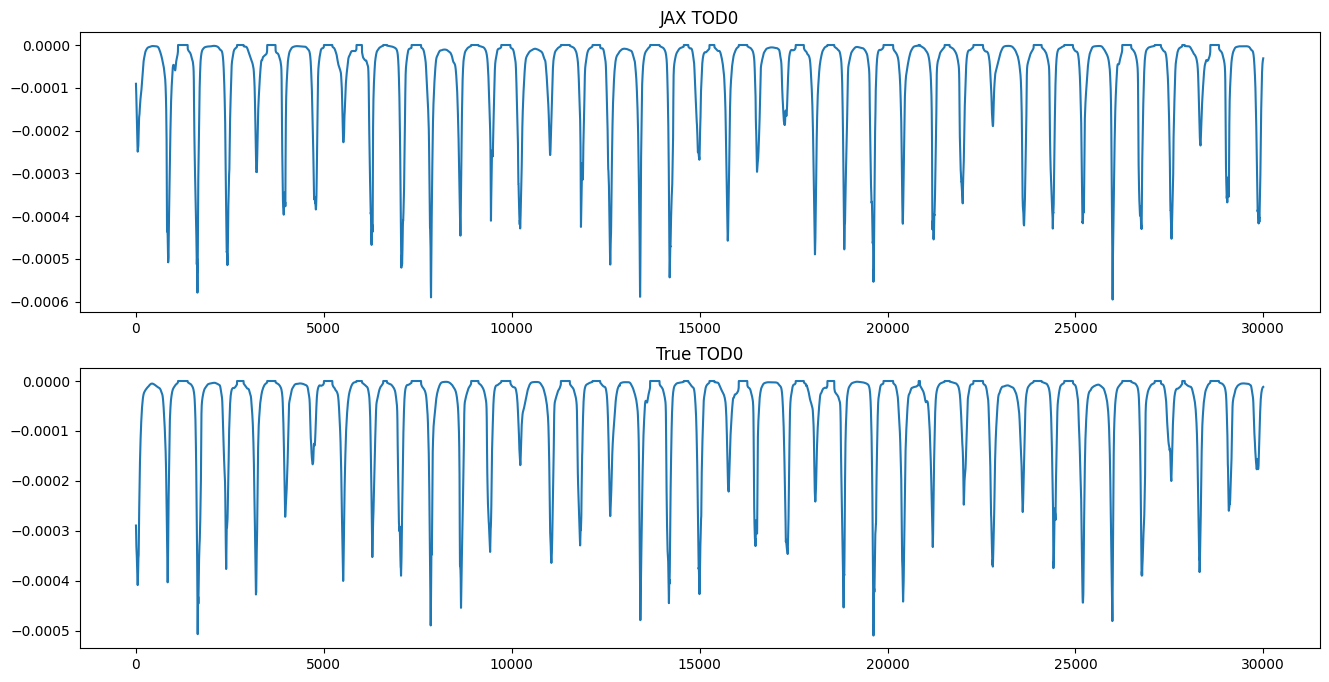

In [116]:

# jax_tods = sample_maps(sim_truthmap.map.data, dx, dy, instrument, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
jax_tods = sample_maps(mapdata_truth, dx, dy, instrument, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

im0 = axes[0].plot(jax_tods[0])
axes[0].title.set_text('JAX TOD0')

tods_map = np.float64(tod_truthmap.data.compute())
im1 = axes[1].plot(tods_map[0])
axes[1].title.set_text('True TOD0')

plt.show()

In [134]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init)

    def __call__(self, x):
        return sample_maps(self.gp_map(x), dx, dy, instrument, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        # return self.gp_map(x)

class Signal_map(jft.Model):
    def __init__(self, gp_map):
        self.gp_map = gp_map
        super().__init__(init=self.gp_map.init)

    def __call__(self, x):
        # return sample_maps(self.gp_map(x), dx, dy, instrument, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
        return self.gp_map(x)
  
signal_response_tod = Signal_TOD(gp_map)
signal_response_map = Signal_map(gp_map)

# Define noise covariance
# noise_cov_inv = lambda x: 1e-1**-2 * x # 10% noise
noise_cov_inv_map = lambda x: 1e-1**-2 * x # 10% noise
noise_cov_inv_tod = lambda x: 5e-6**-2 * x

# Combine in likelihood
tods_map = np.float64(tod_truthmap.data.compute())
# lh_tod = jft.Gaussian( tods_map, noise_cov_inv).amend(signal_response_tod)
lh_tod = jft.Gaussian( jax_tods, noise_cov_inv_tod).amend(signal_response_tod)
# lh_map = jft.Gaussian( mapdata_input, noise_cov_inv).amend(signal_response_map) # true map
lh_map = jft.Gaussian( mapdata_truth[0], noise_cov_inv_map).amend(signal_response_map) # true map

# lh = jft.Model(lambda x: lh_tod(x) + lh_map(x), init=lh_tod.init | lh_map.init)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`
assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


# MAP fit

In [135]:
n_it = 1
# delta = 1e-4 # default
delta = 1e-10 # here
n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001
M: →:1.0 ↺:False #∇²:06 |↘|:2.043220e+02 ➽:1.158269e-04
M: Iteration 1 ⛰:+4.459635e+15 Δ⛰:9.532221e+15
M: →:1.0 ↺:False #∇²:12 |↘|:6.157893e+01 ➽:1.158269e-04
M: Iteration 2 ⛰:+5.890639e+13 Δ⛰:4.400728e+15
M: →:1.0 ↺:False #∇²:18 |↘|:6.315647e+01 ➽:1.158269e-04
M: Iteration 3 ⛰:+8.071300e+12 Δ⛰:5.083509e+13
M: →:1.0 ↺:False #∇²:24 |↘|:4.837930e+01 ➽:1.158269e-04
M: Iteration 4 ⛰:+1.384305e+12 Δ⛰:6.686995e+12
M: →:1.0 ↺:False #∇²:30 |↘|:4.673561e+01 ➽:1.158269e-04
M: Iteration 5 ⛰:+4.350299e+11 Δ⛰:9.492752e+11
M: →:1.0 ↺:False #∇²:36 |↘|:4.840679e+01 ➽:1.158269e-04
M: Iteration 6 ⛰:+2.469110e+11 Δ⛰:1.881189e+11
M: →:1.0 ↺:False #∇²:42 |↘|:6.019480e+01 ➽:1.158269e-04
M: Iteration 7 ⛰:+1.092184e+11 Δ⛰:1.376926e+11
M: →:1.0 ↺:False #∇²:48 |↘|:2.581509e+01 ➽:1.158269e-04
M: Iteration 8 ⛰:+4.408051e+10 Δ⛰:6.513791e+10
M: →:1.0 ↺:False #∇²:54 |↘|:4.686323e+00 ➽:1.158269e-04
M: Iteration 9 ⛰:+5.159660e+09 Δ⛰:3.892085e+10
M: →:0.25 ↺:False #∇²:60 |↘|:6.429242e+00 ➽:1.

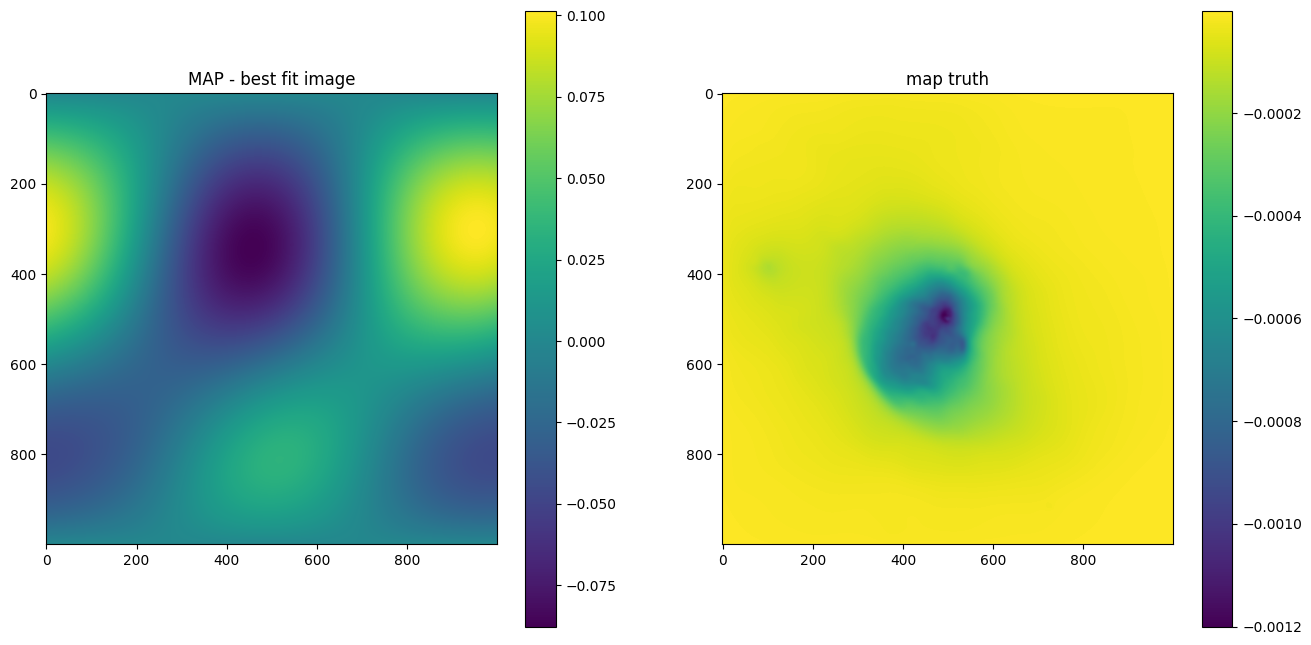

In [136]:
# plot maximum of posterior (mode)
# sig_map = signal_response(samples.pos) # gives time-series
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( mapdata_truth[0] )
axes[1].title.set_text('map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

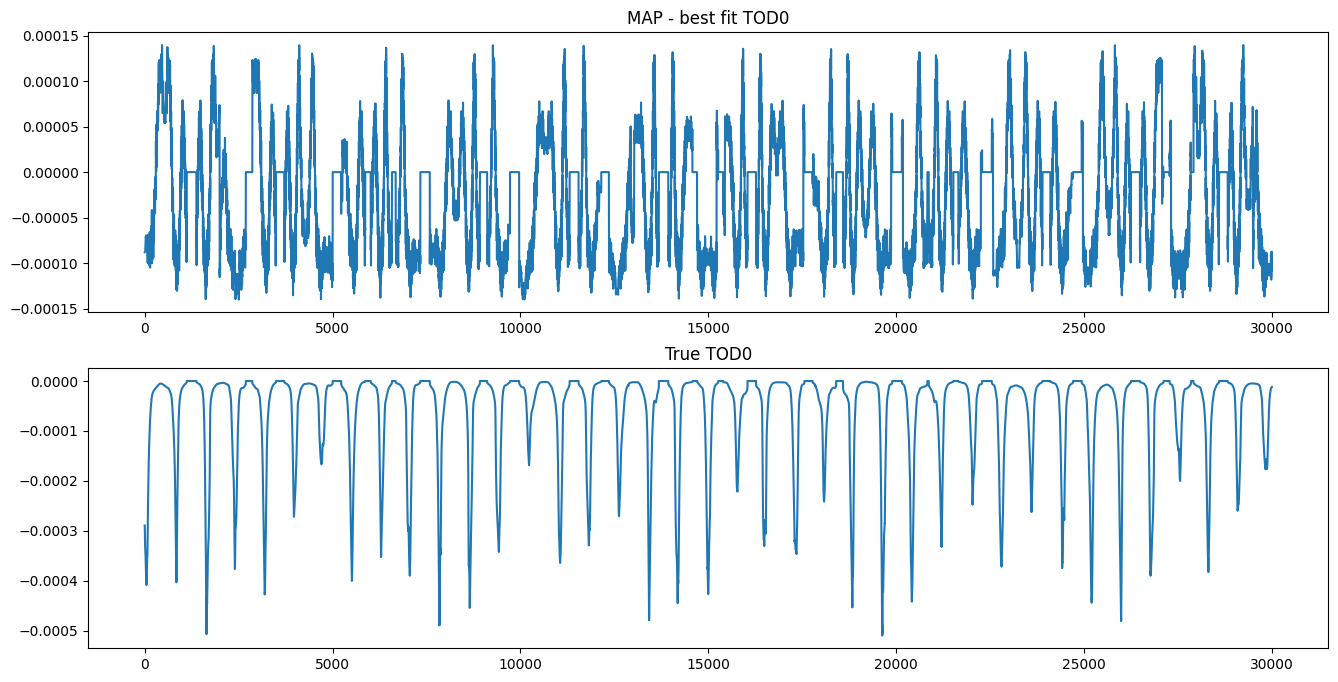

In [137]:
# plot maximum of posterior (mode)
pred_tods = signal_response_tod(samples.pos) # gives time-series
# sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

im0 = axes[0].plot(pred_tods[0])
axes[0].title.set_text('MAP - best fit TOD0')

im1 = axes[1].plot(tods_map[0])
axes[1].title.set_text('True TOD0')

plt.show()

In [22]:
assert False

AssertionError: 

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+7.6007e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:+4.2573e+05 Δ⛰:3.3434e+05 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.2782e+03 Δ⛰:4.3101e+05 ➽:1.1583e-03
SL: Iteration 3 ⛰:-2.8336e+05 Δ⛰:2.7808e+05 ➽:1.1583e-03
SL: Iteration 4 ⛰:-4.6009e+05 Δ⛰:1.7673e+05 ➽:1.1583e-03
SL: Iteration 5 ⛰:-5.0844e+05 Δ⛰:4.8344e+04 ➽:1.1583e-03
SL: Iteration 6 ⛰:-5.2608e+05 Δ⛰:1.7645e+04 ➽:1.1583e-03
SL: Iteration 7 ⛰:-5.3899e+05 Δ⛰:1.2911e+04 ➽:1.1583e-03
SL: Iteration 8 ⛰:-5.4962e+05 Δ⛰:1.0634e+04 ➽:1.1583e-03
SL: Iteration 9 ⛰:-5.5669e+05 Δ⛰:7.0671e+03 ➽:1.1583e-03
SL: Iteration 10 ⛰:-5.6151e+05 Δ⛰:4.8206e+03 ➽:1.1583e-03
SL: Iteration 11 ⛰:-5.6515e+05 Δ⛰:3.6402e+03 ➽:1.1583e-03
SL: Iteration 12 ⛰:-5.6557e+05 Δ⛰:4.1311e+02 ➽:1.1583e-03
SL: Iteration 13 ⛰:-5.6823e+05 Δ⛰:2.6679e+03 ➽:1.1583e-03
SL: Iteration 14 ⛰:-5.7020e+05 Δ⛰:1.9686e+03 ➽:1.1583e-03
SL: Iteration 15 ⛰:-5.7176e+05 Δ⛰:1.5537e+03 ➽:1.1583e-03
SL: Iteration 16 ⛰:-5.7295e+05 Δ⛰:1.1939e+03 ➽:1.1583e-03
SL: 

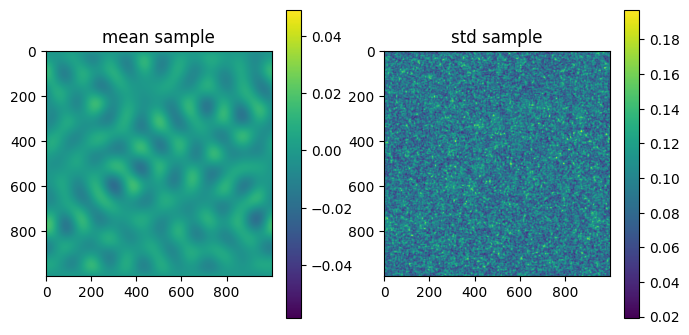

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:-5.7882e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:-5.7892e+05 Δ⛰:9.4085e+01 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.7896e+05 Δ⛰:4.2254e+01 ➽:1.1583e-03
SL: Iteration 3 ⛰:-5.7897e+05 Δ⛰:1.1975e+01 ➽:1.1583e-03
SL: Iteration 4 ⛰:-5.7898e+05 Δ⛰:4.1852e+00 ➽:1.1583e-03
SL: Iteration 5 ⛰:-5.7898e+05 Δ⛰:1.0707e+00 ➽:1.1583e-03
SL: Iteration 6 ⛰:-5.7898e+05 Δ⛰:5.8576e-01 ➽:1.1583e-03
SL: Iteration 7 ⛰:-5.7898e+05 Δ⛰:2.3440e-01 ➽:1.1583e-03
SL: Iteration 8 ⛰:-5.7898e+05 Δ⛰:6.4016e-02 ➽:1.1583e-03
SL: Iteration 9 ⛰:-5.7898e+05 Δ⛰:1.8472e-02 ➽:1.1583e-03
SL: Iteration 10 ⛰:-5.7898e+05 Δ⛰:5.2048e-03 ➽:1.1583e-03
SL: Iteration 11 ⛰:-5.7898e+05 Δ⛰:2.1301e-03 ➽:1.1583e-03
SL: Iteration 12 ⛰:-5.7898e+05 Δ⛰:4.8019e-04 ➽:1.1583e-03
SL: Iteration 0 ⛰:-5.7938e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:-5.7947e+05 Δ⛰:9.0446e+01 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.7949e+05 Δ⛰:2.4208e+01 ➽:1.1583e-03
SL: Iteration 3 ⛰:-5.7950e+05 Δ⛰:8.4881e+00 ➽:1.1583e-03
SL: Iteration 4

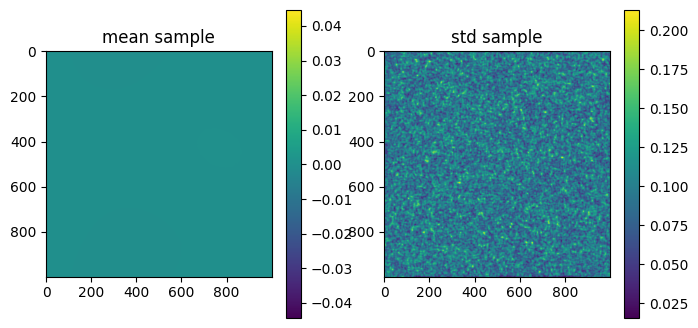

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:-5.7882e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:-5.7892e+05 Δ⛰:9.6230e+01 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.7894e+05 Δ⛰:1.9296e+01 ➽:1.1583e-03
SL: Iteration 3 ⛰:-5.7895e+05 Δ⛰:8.9936e+00 ➽:1.1583e-03
SL: Iteration 4 ⛰:-5.7895e+05 Δ⛰:3.5026e+00 ➽:1.1583e-03
SL: Iteration 5 ⛰:-5.7895e+05 Δ⛰:1.2127e+00 ➽:1.1583e-03
SL: Iteration 6 ⛰:-5.7895e+05 Δ⛰:4.3958e-01 ➽:1.1583e-03
SL: Iteration 7 ⛰:-5.7895e+05 Δ⛰:1.5826e-01 ➽:1.1583e-03
SL: Iteration 8 ⛰:-5.7895e+05 Δ⛰:7.5436e-02 ➽:1.1583e-03
SL: Iteration 9 ⛰:-5.7895e+05 Δ⛰:2.1263e-02 ➽:1.1583e-03
SL: Iteration 10 ⛰:-5.7895e+05 Δ⛰:6.8620e-03 ➽:1.1583e-03
SL: Iteration 11 ⛰:-5.7895e+05 Δ⛰:1.6280e-03 ➽:1.1583e-03
SL: Iteration 12 ⛰:-5.7895e+05 Δ⛰:7.6704e-04 ➽:1.1583e-03
SL: Iteration 0 ⛰:-5.7776e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:-5.7789e+05 Δ⛰:1.2883e+02 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.7792e+05 Δ⛰:2.8463e+01 ➽:1.1583e-03
SL: Iteration 3 ⛰:-5.7793e+05 Δ⛰:6.9470e+00 ➽:1.1583e-03
SL: Iteration 4

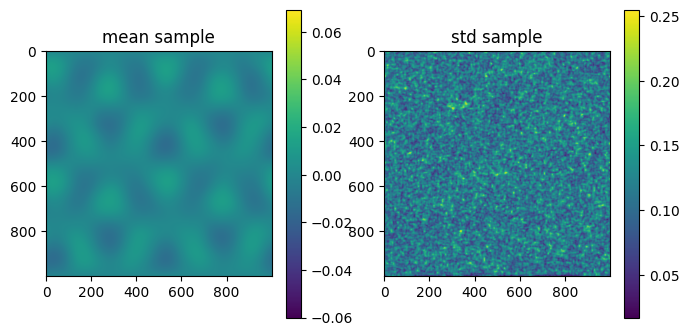

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:-5.7970e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:-5.7996e+05 Δ⛰:2.6476e+02 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.8002e+05 Δ⛰:5.9460e+01 ➽:1.1583e-03
SL: Iteration 3 ⛰:-5.8004e+05 Δ⛰:1.8972e+01 ➽:1.1583e-03
SL: Iteration 4 ⛰:-5.8005e+05 Δ⛰:6.9834e+00 ➽:1.1583e-03
SL: Iteration 5 ⛰:-5.8005e+05 Δ⛰:3.6181e+00 ➽:1.1583e-03
SL: Iteration 6 ⛰:-5.8005e+05 Δ⛰:1.1150e+00 ➽:1.1583e-03
SL: Iteration 7 ⛰:-5.8005e+05 Δ⛰:5.1858e-01 ➽:1.1583e-03
SL: Iteration 8 ⛰:-5.8005e+05 Δ⛰:2.3156e-01 ➽:1.1583e-03
SL: Iteration 9 ⛰:-5.8005e+05 Δ⛰:1.0280e-01 ➽:1.1583e-03
SL: Iteration 10 ⛰:-5.8005e+05 Δ⛰:6.1922e-02 ➽:1.1583e-03
SL: Iteration 11 ⛰:-5.8005e+05 Δ⛰:2.1435e-02 ➽:1.1583e-03
SL: Iteration 12 ⛰:-5.8005e+05 Δ⛰:1.1560e-02 ➽:1.1583e-03
SL: Iteration 13 ⛰:-5.8005e+05 Δ⛰:3.6584e-03 ➽:1.1583e-03
SL: Iteration 14 ⛰:-5.8005e+05 Δ⛰:1.6491e-03 ➽:1.1583e-03
SL: Iteration 15 ⛰:-5.8005e+05 Δ⛰:6.1129e-04 ➽:1.1583e-03
SL: Iteration 0 ⛰:-5.7911e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteratio

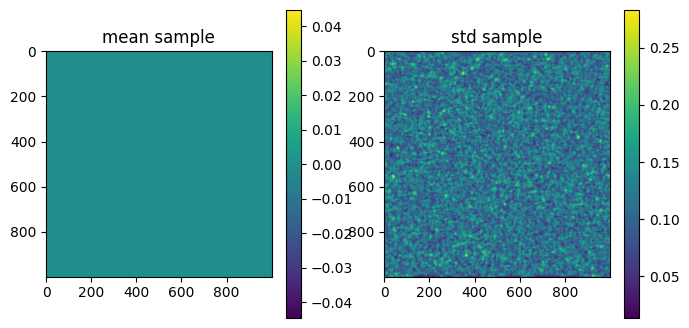

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:-5.7997e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:-5.8015e+05 Δ⛰:1.8121e+02 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.8020e+05 Δ⛰:5.4529e+01 ➽:1.1583e-03
SL: Iteration 3 ⛰:-5.8022e+05 Δ⛰:1.6005e+01 ➽:1.1583e-03
SL: Iteration 4 ⛰:-5.8022e+05 Δ⛰:6.1290e+00 ➽:1.1583e-03
SL: Iteration 5 ⛰:-5.8023e+05 Δ⛰:2.3265e+00 ➽:1.1583e-03
SL: Iteration 6 ⛰:-5.8023e+05 Δ⛰:1.6063e+00 ➽:1.1583e-03
SL: Iteration 7 ⛰:-5.8023e+05 Δ⛰:4.3938e-01 ➽:1.1583e-03
SL: Iteration 8 ⛰:-5.8023e+05 Δ⛰:2.3572e-01 ➽:1.1583e-03
SL: Iteration 9 ⛰:-5.8023e+05 Δ⛰:1.0070e-01 ➽:1.1583e-03
SL: Iteration 10 ⛰:-5.8023e+05 Δ⛰:5.0949e-02 ➽:1.1583e-03
SL: Iteration 11 ⛰:-5.8023e+05 Δ⛰:2.2020e-02 ➽:1.1583e-03
SL: Iteration 12 ⛰:-5.8023e+05 Δ⛰:1.0160e-02 ➽:1.1583e-03
SL: Iteration 13 ⛰:-5.8023e+05 Δ⛰:4.0137e-03 ➽:1.1583e-03
SL: Iteration 14 ⛰:-5.8023e+05 Δ⛰:1.7732e-03 ➽:1.1583e-03
SL: Iteration 15 ⛰:-5.8023e+05 Δ⛰:7.2634e-04 ➽:1.1583e-03
SL: Iteration 0 ⛰:-5.7928e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteratio

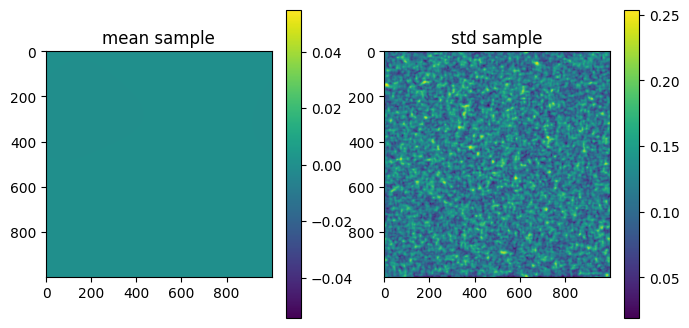

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:-5.8059e+05 Δ⛰:inf ➽:1.1583e-03
SL: Iteration 1 ⛰:-5.8087e+05 Δ⛰:2.7357e+02 ➽:1.1583e-03
SL: Iteration 2 ⛰:-5.8090e+05 Δ⛰:3.5074e+01 ➽:1.1583e-03
SL: Iteration 3 ⛰:-5.8091e+05 Δ⛰:9.7950e+00 ➽:1.1583e-03
SL: Iteration 4 ⛰:-5.8092e+05 Δ⛰:5.1287e+00 ➽:1.1583e-03
SL: Iteration 5 ⛰:-5.8092e+05 Δ⛰:2.2916e+00 ➽:1.1583e-03
SL: Iteration 6 ⛰:-5.8092e+05 Δ⛰:1.2476e+00 ➽:1.1583e-03
SL: Iteration 7 ⛰:-5.8092e+05 Δ⛰:5.3375e-01 ➽:1.1583e-03
SL: Iteration 8 ⛰:-5.8092e+05 Δ⛰:2.8070e-01 ➽:1.1583e-03
SL: Iteration 9 ⛰:-5.8092e+05 Δ⛰:9.1069e-02 ➽:1.1583e-03
SL: Iteration 10 ⛰:-5.8092e+05 Δ⛰:3.8559e-02 ➽:1.1583e-03
SL: Iteration 11 ⛰:-5.8092e+05 Δ⛰:4.4507e-02 ➽:1.1583e-03
SL: Iteration 12 ⛰:-5.8092e+05 Δ⛰:1.0050e-02 ➽:1.1583e-03
SL: Iteration 13 ⛰:-5.8092e+05 Δ⛰:6.2935e-03 ➽:1.1583e-03
SL: Iteration 14 ⛰:-5.8092e+05 Δ⛰:2.5767e-03 ➽:1.1583e-03
SL: Iteration 15 ⛰:-5.8092e+05 Δ⛰:1.2181e-03 ➽:1.1583e-03
SL: Iteration 16 ⛰:-5.8092e+05 Δ⛰:3.7715e-04 ➽:1.1583e-03
SL: 

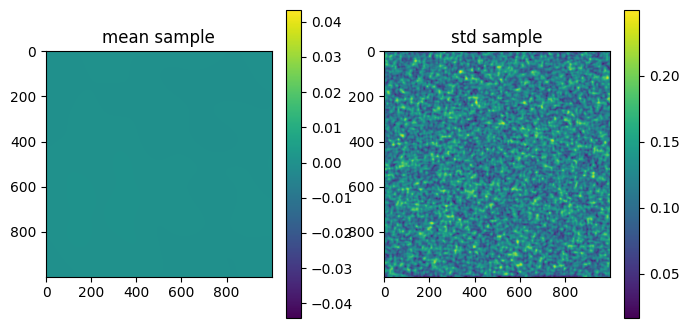

In [78]:
n_it = 6
# delta = 1e-4
delta = 1e-8
n_samples = 8 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(gp_map(s) for s in samples))
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    im0 = axes[0].imshow(mean)
    axes[0].title.set_text('mean sample')
    fig.colorbar(im0)

    im1 = axes[1].imshow(std)
    axes[1].title.set_text('std sample')
    fig.colorbar(im1)
    
    plt.show()

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=100),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=100
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    callback=callback,
)

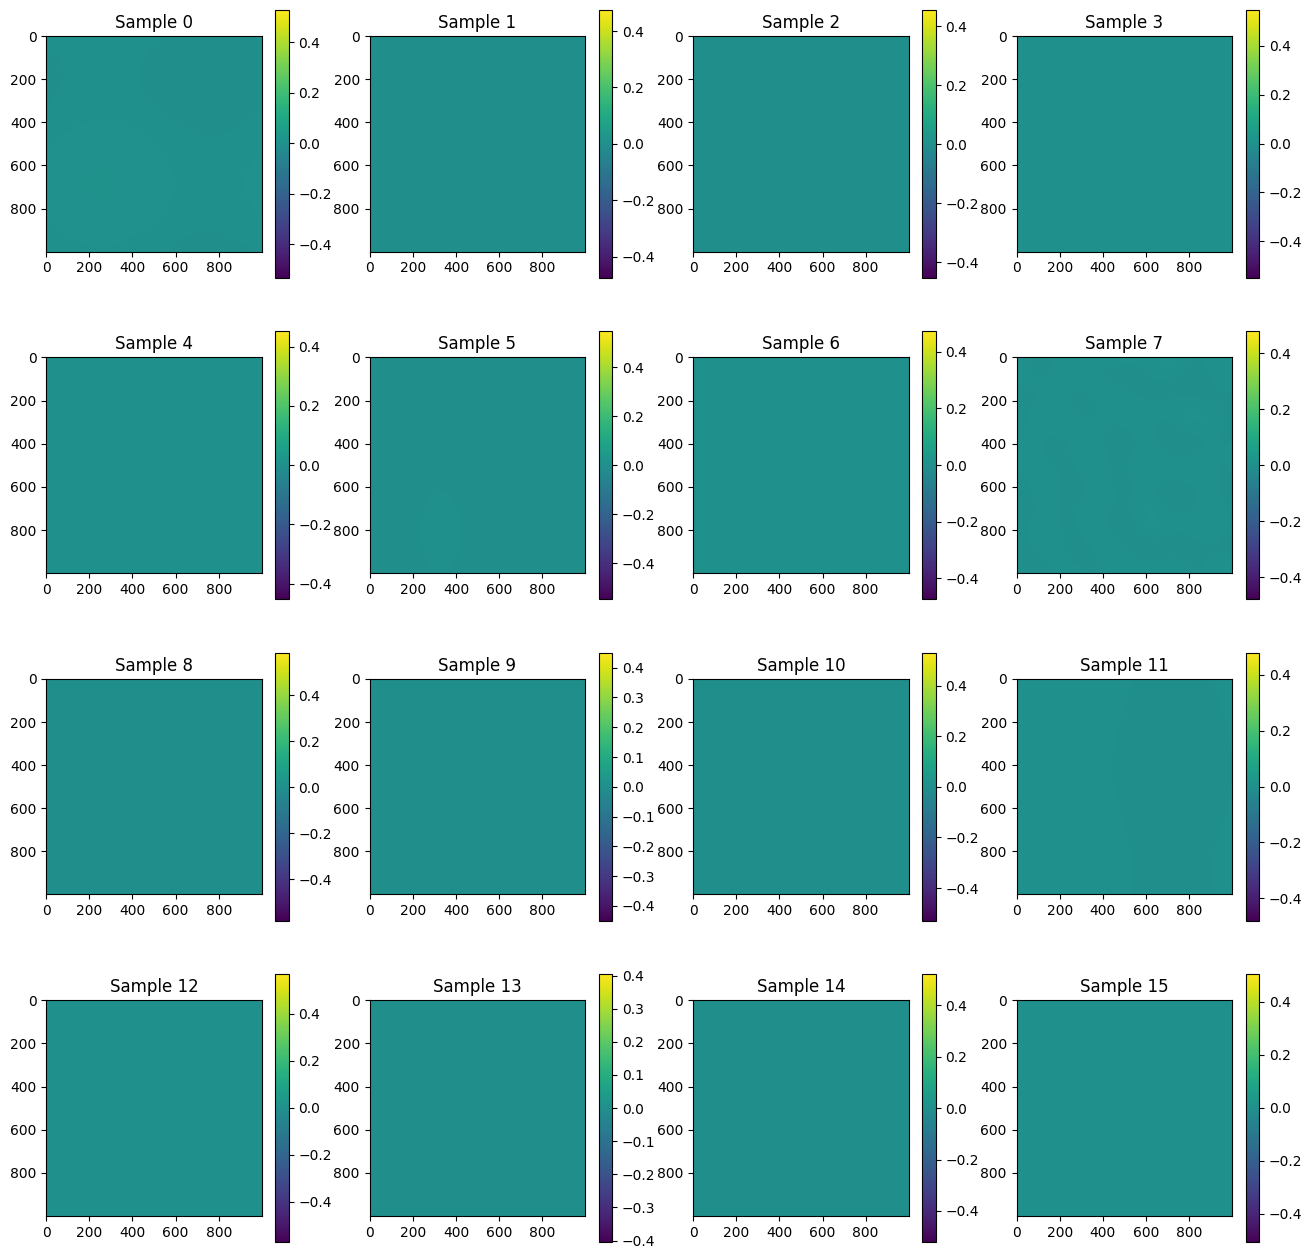

In [79]:
# plot all samples
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

i = 0
for s in samples:
    # print(i//4, i%4)
    # im = axes[i//4][i%4].imshow(signal_response(s))
    im = axes[i//4][i%4].imshow(gp_map(s))
    axes[i//4][i%4].title.set_text(f"Sample {i}")
    fig.colorbar(im)
    
    i += 1

plt.show()